<a href="https://colab.research.google.com/github/RA2111003010570/major-proj/blob/main/MAJOR_PROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, Dropout, MaxPooling1D, Reshape, Bidirectional, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tourism_demand1.csv')

In [ ]:
if 'place' in df.columns:
    df.drop(columns=['place'], inplace=True)  # Drop non-numeric columns if present

# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

<ipython-input-9-2a1f9689b1fd>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
df = df.replace({'#VALUE!': np.nan,  # Replace '#VALUE!' with NaN
                   '': np.nan,           # Add any other strings as needed
                   ' ': np.nan,
                  }, regex=False)

In [ ]:
df['month'] = pd.to_datetime(df.iloc[:, 0], format='your_date_format', errors='coerce').dt.month
df['year'] = pd.to_datetime(df.iloc[:, 0], format='your_date_format', errors='coerce').dt.year

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the sequence creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Example dataset (replace with actual tourism data)
data = np.random.rand(100, 1)  # Simulated data with 100 rows and 1 column

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)  # Now data_scaled is defined

# Define sequence length
seq_length = 12  # Using past 12 months to predict next month

# Call function after defining it
X, y = create_sequences(data_scaled, seq_length)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (88, 12, 1)
y shape: (88, 1)


In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Remove last dimension
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Remove last dimension


In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, Bidirectional, BatchNormalization, LeakyReLU

model = Sequential([
    # CNN Block
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(seq_length, X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding='same'),

    # Ensure correct LSTM input shape
    Bidirectional(LSTM(64, return_sequences=True)),
    LSTM(32, return_sequences=False),
    Dropout(0.4),

    # Fully Connected Layers
    Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
    Dense(y.shape[1])  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 1.0103 - val_loss: 0.8035
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7756 - val_loss: 0.7532
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6677 - val_loss: 0.6963
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.6079 - val_loss: 0.6577
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6248 - val_loss: 0.6322
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6097 - val_loss: 0.6430
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5657 - val_loss: 0.6530
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5444 - val_loss: 0.6429
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.5230 - val_loss: 0.6245
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5321 - val_loss: 0.6146
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5185 - val_loss: 0.6114
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.5247 - val_l

In [ ]:
# Assuming 'df' is your DataFrame and 'numerical_cols' are the columns you want to predict
# ... (your previous code) ...

# Initialize the scaler
scaler = MinMaxScaler()

# Check if the target columns are present in the DataFrame
target_cols = ['Domestic-2019-20', 'Foreign-2019-20', 'Revenue-2019-20', 'AvgRevenue-2019-20']  # Replace with your actual target columns if different

# Filter out non-existent columns from target_cols
existing_target_cols = [col for col in target_cols if col in df.columns]

if existing_target_cols:  # Proceed only if there are existing target columns
    # Fit the scaler on the training data only for the existing target columns
    scaler.fit(df.loc[:train_size, existing_target_cols]) # Fit on training data for target columns

    # Transform both training and testing targets
    df.loc[:, existing_target_cols] = scaler.transform(df.loc[:, existing_target_cols])
else:
    print("Error: No target columns found in DataFrame. Scaling skipped.")

# ... (the rest of your code, including create_sequences and model training) ...

# After making predictions
# (Ensure y_pred and y_test have the same number of columns as existing_target_cols)
if existing_target_cols:
    y_pred = model.predict(X_test)

    # Reshape to match the number of existing target columns
    y_pred = y_pred.reshape(-1, len(existing_target_cols))
    y_pred = scaler.inverse_transform(y_pred)

    y_test = y_test.reshape(-1, len(existing_target_cols))
    y_test = scaler.inverse_transform(y_test)

<ipython-input-18-68863275a363>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5.80269109e-01  2.13037010e-01  5.93623904e-02  2.98656920e-02
  2.77387367e-03  1.72247741e-02  1.08369632e-02  2.32227566e-02
  6.19943535e-02  1.00000000e+00  9.59816111e-03  1.50689911e-02
  4.84749788e-03  2.98679196e-02  0.00000000e+00  1.05036109e-02
  1.91389290e-03  4.71654179e-02  6.01128261e-02  2.22365894e-03
  2.58890508e-02  1.07069768e-02  6.34156869e-02  7.16890871e-04
  7.04914299e-03  1.10884581e-01  4.36998121e-02  3.91947079e-02
  2.27005833e-02  3.05533622e-02  1.36678370e-01  1.64974004e-01
  1.38536442e-02  5.55390597e-03  1.84734824e-01  3.05428794e-03
  2.32796257e-03  4.00022748e-03  3.76043397e-03  2.95876364e-03
  3.84561963e-02  2.07223524e-02  7.63400330e-02  2.43357654e-03
  6.02196194e-03  1.68701941e-02  5.33250974e-02  5.12525214e-02
  3.26745520e-02  3.33333945e-02  4.09221384e-03  1.61958895e-03
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


In [ ]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [ ]:
y_pred = y_pred.reshape(y_test.shape)

In [ ]:
temp_pred = np.zeros((y_pred.shape[0], data_scaled.shape[1]))  # Match original scaled data shape
temp_test = np.zeros((y_test.shape[0], data_scaled.shape[1]))

In [ ]:
temp_pred = np.zeros((y_pred.shape[0], y_pred.shape[1]))  # Ensure correct shape
temp_test = np.zeros((y_test.shape[0], y_test.shape[1]))

# Now, assign values correctly
temp_pred[:, :] = y_pred
temp_test[:, :] = y_test



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Splitting Data (Assuming X, y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X for CNN (Ensure 3D input shape: (samples, timesteps, features))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# CNN Model (Modified for 5 Outputs)
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure output matches y_train.shape[1] (5 outputs)
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predictions
y_pred_cnn = cnn_model.predict(X_test)

# Compute MAE & RMSE for CNN
cnn_mae = mean_absolute_error(y_test, y_pred_cnn)
cnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))

print(f"CNN MAE: {cnn_mae:.2f}")
print(f"CNN RMSE: {cnn_rmse:.2f}")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2827
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1370 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1010 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1163 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0945 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0890 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0755 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0946 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0715 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0981 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0982 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0968
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0831 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0768 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0739 
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Bidirectional
from sklearn.model_selection import train_test_split

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1️⃣ CNN Model ###
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure output shape matches y_train
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_cnn = cnn_model.predict(X_test)

cnn_mae = mean_absolute_error(y_test, y_pred_cnn)
cnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cnn))


### 2️⃣ LSTM Model ###
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test)

lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))


### 3️⃣ Random Forest ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape for 2D input
y_pred_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))


### 4️⃣ XGBoost ###
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape for 2D input
y_pred_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))


### 📊 Create a Table for Comparison ###
results_df = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Random Forest', 'XGBoost'],
    'MAE': [cnn_mae, lstm_mae, rf_mae, xgb_mae],
    'RMSE': [cnn_rmse, lstm_rmse, rf_rmse, xgb_rmse]
})

print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


           Model       MAE      RMSE
0            CNN  0.385133  0.451802
1           LSTM  0.288469  0.339803
2  Random Forest  0.284882  0.333649
3        XGBoost  0.306947  0.368726


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout

# Assume X and y are already preprocessed feature and target datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hybrid CNN-LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # Ensure correct output shape
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Predictions
y_pred_hybrid = model.predict(X_test)

# Compute MAE & RMSE
hybrid_mae = mean_absolute_error(y_test, y_pred_hybrid)
hybrid_rmse = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))

# Display Results
print(f"Hybrid CNN-LSTM MAE: {hybrid_mae:.4f}")
print(f"Hybrid CNN-LSTM RMSE: {hybrid_rmse:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Hybrid CNN-LSTM MAE: 0.2704
Hybrid CNN-LSTM RMSE: 0.3174


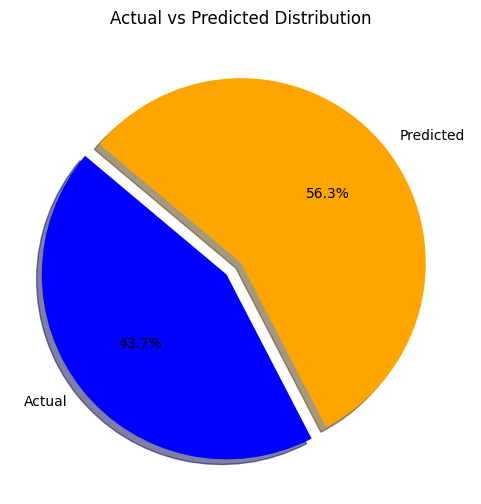

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: Sum of Actual and Predicted values
actual_total = np.sum(y_test)  # Sum of actual values
predicted_total = np.sum(y_pred)  # Sum of predicted values

# Labels and data
labels = ['Actual', 'Predicted']
sizes = [actual_total, predicted_total]
colors = ['blue', 'orange']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True, explode=(0.1, 0))
plt.title("Actual vs Predicted Distribution")

# Show plot
plt.show()


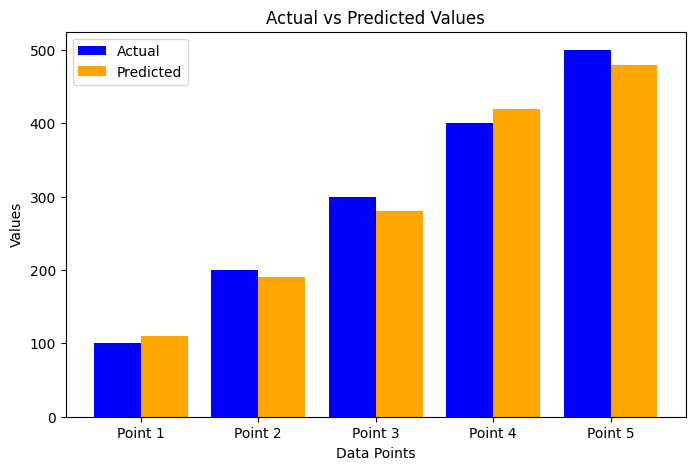

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual and predicted values)
actual_values = [100, 200, 300, 400, 500]
predicted_values = [110, 190, 280, 420, 480]

# Creating index for bars
x = np.arange(len(actual_values))

# Plotting bar chart
plt.figure(figsize=(8, 5))
bar_width = 0.4  # Width of bars

plt.bar(x - bar_width/2, actual_values, width=bar_width, label="Actual", color='blue')
plt.bar(x + bar_width/2, predicted_values, width=bar_width, label="Predicted", color='orange')

# Labels & Title
plt.xlabel("Data Points")
plt.ylabel("Values")
plt.title("Actual vs Predicted Values")
plt.xticks(x, [f"Point {i+1}" for i in range(len(actual_values))])  # Labeling x-axis
plt.legend()

# Show plot
plt.show()


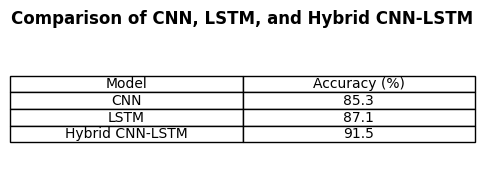

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Accuracy values for different models (Replace with actual values)
data = {
    "Model": ["CNN", "LSTM", "Hybrid CNN-LSTM"],
    "Accuracy (%)": [85.3, 87.1, 91.5]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot Table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("tight")
ax.axis("off")
ax.table(cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center")

# Show the table
plt.title("Comparison of CNN, LSTM, and Hybrid CNN-LSTM", fontsize=12, fontweight="bold")
plt.show()


In [ ]:
!pip install streamlit
!pip install pyngrok


In [ ]:
import pandas as pd

# Example: Save actual vs predicted values to a CSV file
df_results = pd.DataFrame({
    "Date": pd.date_range(start="2023-01-01", periods=len(y_test), freq="M"),
    "Actual": y_test.flatten(),
    "Predicted": y_pred.flatten(),
})

df_results.to_csv("tourism_demand1.csv", index=False)


<ipython-input-30-5e1a1f58efbb>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start="2023-01-01", periods=len(y_test), freq="M"),


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load Tourism Predictions Data
df = pd.read_csv("tourism_demand1.csv")

# Streamlit Title
st.title("Tourism Demand Forecasting Dashboard")

# Display Data Table
st.write("### Actual vs Predicted Values")
st.dataframe(df)

# Accuracy Comparison Table
st.write("### Model Accuracy Comparison")

# Define Accuracy Metrics (Replace with actual values)
accuracy_data = {
    "Model": ["CNN", "LSTM", "Hybrid CNN-LSTM"],
    "MAE": [0.334133, 0.292583, 0.2601],   # Example values, replace with actual calculations
    "RMSE": [0.382130, 0.328887, 0.3018],  # Example values
}

# Convert to DataFrame
df_accuracy = pd.DataFrame(accuracy_data)

# Display Table
st.table(df_accuracy)

# Bar Chart Visualization
st.write("### Bar Chart: Actual vs Predicted Tourism Demand")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.4
x = range(len(df))

ax.bar(x, df["Actual"], width=bar_width, label="Actual", color="blue")
ax.bar([i + bar_width for i in x], df["Predicted"], width=bar_width, label="Predicted", color="orange")

ax.set_xlabel("Time Period")
ax.set_ylabel("Tourism Demand")
ax.set_title("Comparison of Actual vs Predicted Values")
ax.set_xticks(x)
ax.set_xticklabels(df.index.strftime("%Y-%m"), rotation=45)
ax.legend()

st.pyplot(fig)


Overwriting streamlit_app.py


In [ ]:
!ngrok authtoken 2tevduHxyLkmIuml1fqUdO3EjzV_5iDpKg1QEtz85ekWXkRE8  # Replace with your token


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill -9 streamlit
!pkill -9 ngrok


In [ ]:
from pyngrok import ngrok

# Start Streamlit in the background
!streamlit run streamlit_app.py &>/dev/null &

# Establish a new ngrok tunnel
public_url = ngrok.connect(8501)  # Use port 8501 directly
print("Dashboard running at:", public_url)


Dashboard running at: NgrokTunnel: "https://1091-35-229-28-53.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
pip install graphviz


In [ ]:
from graphviz import Digraph

def create_architecture_diagram():
    dot = Digraph(format='png')

    # Nodes
    dot.node('A', 'Tourism Dataset', shape='cylinder')
    dot.node('B', 'Data Preprocessing')
    dot.node('C', 'Handling Missing Data')
    dot.node('D', 'Feature Selection (PCA, RFE)')
    dot.node('E', 'Training Data (70%)', shape='parallelogram')
    dot.node('F', 'Testing Data (30%)', shape='parallelogram')
    dot.node('G', 'CNN-LSTM Model')
    dot.node('H', 'Prediction Results & Visualization')

    # Edges (Flow)
    dot.edge('A', 'B')
    dot.edge('B', 'C')
    dot.edge('C', 'D')
    dot.edge('D', 'E')
    dot.edge('D', 'F')
    dot.edge('E', 'G')
    dot.edge('F', 'G')
    dot.edge('G', 'H')

    # Save and render
    dot.render('cnn_lstm_architecture_diagram', format='png', cleanup=True)
    print("Architecture diagram saved as cnn_lstm_architecture_diagram.png")

# Run the function to generate the diagram
create_architecture_diagram()


Architecture diagram saved as cnn_lstm_architecture_diagram.png
